In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import iso8601

from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d

from scipy.optimize import curve_fit
from filterpy.kalman import UnscentedKalmanFilter as UKF

# Read files

In [1]:
def read_file(filename):
    '''Read Bloomie's output file.'''
    
    # Read the file
    gc = pd.read_csv(filename, sep = '\t', keep_default_na=False)
    
    # Parse time and calculate minutes elapsed since the start of the experiment
    gc["time"] = [iso8601.parse_date(t).timestamp() for t in gc["time"]]
    gc["elapsed_raw"] = (gc.time - np.min(gc.time)) / 60
    
    return gc

def read_file_raw(filename):
    '''Read the device's raw file.'''
    
    # Read the file
    gc = pd.read_csv(filename, sep = ',', skiprows = 1, keep_default_na=False)
        
    # Parse time and calculate minutes elapsed since the start of the experiment
    gc.rename(columns = {'timestamp': 'time'}, inplace = True)
    gc["time"] = [iso8601.parse_date(t).timestamp() for t in gc["time"]]
    gc["elapsed_raw"] = (gc.time - np.min(gc.time)) / 60
    gc["converted_od"] = gc.converted_od.astype(float)
    
    gc['position'] = 'D' + gc.device.astype(str) + 'C' + gc.channel.astype(str)

    return gc

In [3]:
filename = ""
experiment_name = ''

gc = read_file(filename)

# Assign samples

In [1]:
# If the samples weren't already named
gc.rename(columns = {'name': 'position'}, inplace = True)

position_to_well = {
 'D2C0': 'H1',
 'D2C1': 'W2',
 'D2C2': 'A2',
 'D2C3': 'B2',
 'D2C4': 'C2',
 'D2C5': 'D2',
 'D2C6': 'E2',
 'D2C7': 'F2',
 'D3C0': 'W1',
 'D3C1': 'A1',
 'D3C2': 'B1',
 'D3C3': 'C1',
 'D3C4': 'D1',
 'D3C5': 'E1',
 'D3C6': 'F1',
 'D3C7': 'G1',
 'D4C0': 'G2',
 'D4C1': 'H2',
 'D4C2': 'W3',
 'D4C3': 'A3',
 'D4C4': 'B3',
 'D4C5': 'C3',
 'D4C6': 'D3',
 'D4C7': 'E3',
 'D5C0': 'F3',
 'D5C1': 'G3',
 'D5C2': 'H3',
 'D5C3': 'W4',
 'D5C4': 'B4',
 'D5C5': 'C4',
 'D5C6': 'F4',
 'D5C7': 'W5'
}

well_to_name = {
'A': 'A06',
'B': 'A12',
'C': 'A18',
'D': 'A24',
'E': 'F06',
'F': 'F12',
'G': 'F18',
'H': 'F24',
'W': 'W00',
'M': 'M00'
}

gc['well'] = gc['position'].map(position_to_well)
gc['name'] = gc.well.str[0].map(well_to_name)
gc['rep'] = gc.well.str[1]
gc['strain'] = gc['name'].str[0]
gc['gen'] = gc['name'].str[1:3].astype(int)

gc.loc[gc.strain == 'W', 'strain'] = 'WT'

groups = ['well', 'name', 'strain', 'gen', 'rep'] # columns to be used for grouping

NameError: name 'gc' is not defined

<Axes: xlabel='elapsed_raw', ylabel='converted_od'>

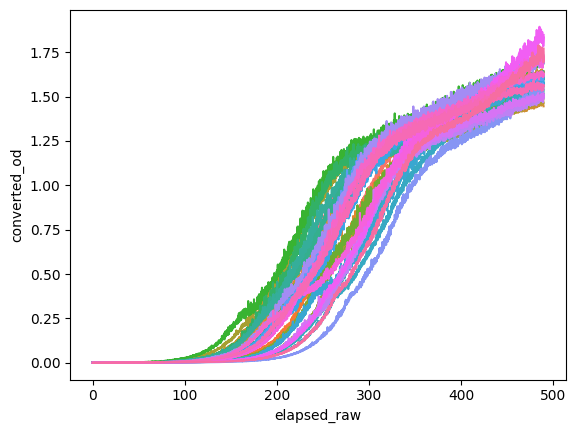

In [5]:
# Plot all the data
sns.lineplot(x = gc.elapsed_raw, y = gc.converted_od, hue = gc.well, style = gc.well, dashes = False, legend = False)

# "well" must define a unique culture

# Crop
Automatically crop the region of interest:
* Remove instability at the beginning due to temperature equilibration
* Remove the points after the curve reached a threshold OD (mostly to avoid when the OD goes down)

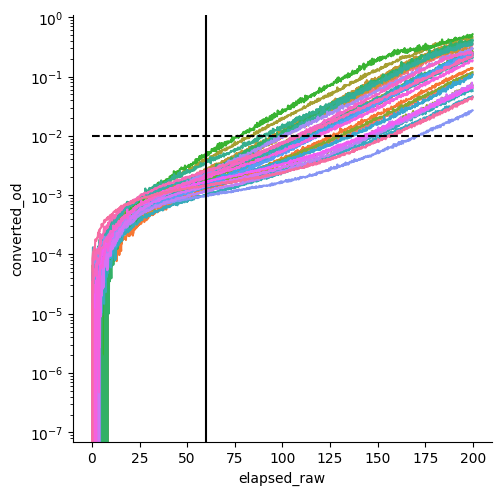

In [7]:
od_limit = 0.7
warmup_time = 45
blank_name = ''

plot_max_t = 1e6
plot_max_od = 1e-1

# Plot early stage to decide warmup time (include blank)
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=False)

sub = gc[(gc.converted_od <= plot_max_od) & (gc.elapsed_raw <= plot_max_t)].reset_index()

# Plot cropping lines
sns.lineplot(x = sub.elapsed_raw, y = sub.converted_od, hue = sub.well, legend = False, ax = axes[0])
axes.ravel()[0].set_yscale('log')
axes.ravel()[0].vlines(warmup_time, np.min(gc.converted_od), np.max(gc.converted_od), color = 'black')
axes.ravel()[0].hlines(1e-2, np.min(sub.elapsed_raw), np.max(sub.elapsed_raw), color = 'black', dashes = '--')

# Remove blank if specified
if blank_name:
    gc_no_blank = gc[gc.strain != blank_name].reset_index(drop = True)
else:
    gc_no_blank = gc.copy()
    
# For indication
print(f"All cultures reach at least: {gc_no_blank.groupby('well').converted_od.apply('max').min()}")

# Do the cropping
gc_crop = gc_no_blank[(gc_no_blank.groupby('well')['converted_od'].transform(lambda x: x.shift(-1).expanding().max() < od_limit)) & 
                      (gc_no_blank.elapsed_raw >= warmup_time)].reset_index()

# Plot data after cropping
sns.lineplot(x = gc_crop.elapsed_raw, y = gc_crop.converted_od, hue = gc_crop.well, legend = False, ax = axes[1])

# Remove outliers
Sometimes a value is way too high, often due to a low volume in the tube. To remove the most extreme outliers, calculate how much the values deviate from a median-filtered time series (window: 25) then remove the points who deviate by more than *n* standard deviation.

In [6]:
from scipy.signal import medfilt

medfilt_window_size = 25
outlier_window_size = 5
outlier_thr = 3

gc_crop.sort_values(['well', 'elapsed_raw'], inplace = True)

gc_crop['deviation'] = gc_crop.converted_od - gc_crop.groupby('well').converted_od.transform(lambda x: medfilt(x, kernel_size = medfilt_window_size))
gc_crop['mean_deviation'] = gc_crop.groupby('well').deviation.transform(lambda x: x.abs().rolling(window = outlier_window_size, min_periods = 1, center = True).median())
gc_crop['outlier'] = gc_crop.deviation.abs() / gc_crop.mean_deviation > outlier_thr

# Remove the oultiers
gc_no_outliers = gc_crop[(~gc_crop.outlier)].reset_index(drop = True)

# Plot for inspection
sub = gc_crop[(gc_crop.converted_od < 0.01)]
sns.relplot(x = sub.elapsed_raw, y = sub.converted_od, hue = sub.outlier, legend = False, col = sub.well, col_wrap = 4)
plt.yscale('log')

# Determine the blanks
First, let's determine the blank by fitting an exponential to the early stages of the curve.

In [36]:
growth_rate_guess = 18

ini_min_od = 0
ini_max_od = 0.05


od_sync = 0.001 # align the curves so they reach this value at t = 0

initial_guesses = [0, 0, growth_rate_guess] # [blank, od_zero, tau]

# Take the beginning of the experiment
gc_expo = gc_no_outliers[gc_no_outliers.groupby('well')['converted_od'].transform(lambda x: x.expanding().max() <= ini_max_od)].reset_index(drop = True)
gc_expo = gc_expo[gc_expo.groupby('well')['converted_od'].transform(lambda x: x.expanding().max() >= ini_min_od)].reset_index(drop = True)

# Define the nonlinear exponential growth model
def exponential_with_blank(elapsed, blank, od_zero, tau):
    return blank + od_zero * 2 ** (elapsed / tau)

# Function to fit the model for a group
def fit_exponential_with_blank(group):
    elapsed = group['elapsed_raw']
    converted_od = group['converted_od']
    sigmas = np.maximum(converted_od, 1e-9) # since the noise is roughly proportional to OD, use this to weight the data
    
    try:
        p_opt, _ = curve_fit(
            exponential_with_blank, 
            elapsed, 
            converted_od, 
            sigma = sigmas,
            p0 = initial_guesses)
        
    except RuntimeError:
        print(f'Failed fitting the curve for {group.well[0]}')
        p_opt = [np.nan, np.nan, np.nan]  # If fitting fails, return NaNs
        
    return pd.Series({'blank': p_opt[0], 'ini_od_zero': p_opt[1], 'ini_tau': p_opt[2]})

# Fit the model and add parameters to the DataFrame
group_params_ini = gc_expo.groupby(groups).apply(fit_exponential_with_blank, include_groups = False).reset_index()
group_params_ini['t_sync'] = group_params_ini.ini_tau * np.log2((od_sync) / group_params_ini.ini_od_zero)

# Add back to the df
gc_initial_fit = gc_no_outliers.merge(group_params_ini, on=groups, how='left')

gc_initial_fit['t'] = gc_initial_fit.elapsed_raw - gc_initial_fit.t_sync
gc_initial_fit['o'] = gc_initial_fit.converted_od - gc_initial_fit.blank

<Axes: xlabel='gen', ylabel='ini_tau'>

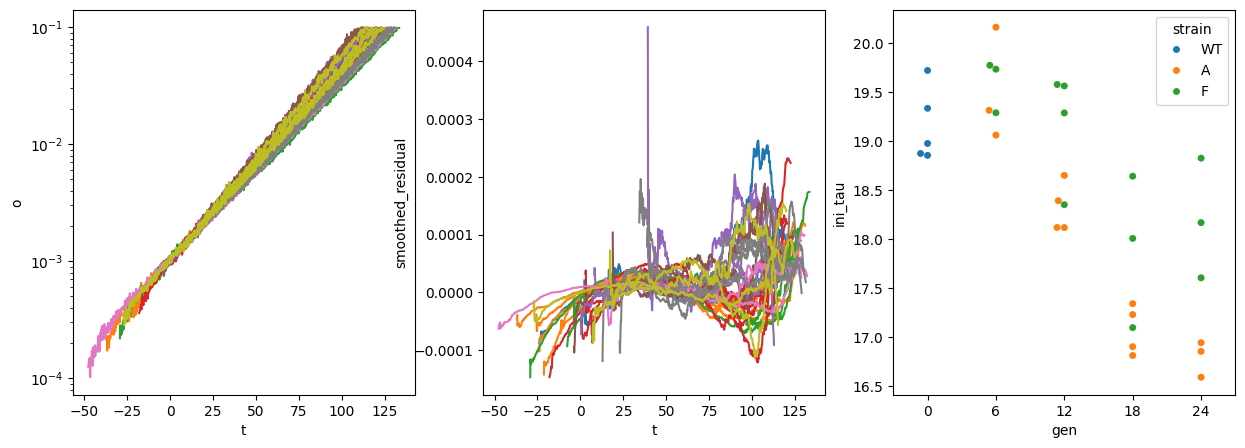

In [37]:
sub = gc_initial_fit[(gc_initial_fit.converted_od < ini_max_od)].reset_index()

# Show residuals
smoothing_window = 1000
sub['pred_od'] = sub.blank + sub.ini_od_zero * 2 ** (sub.elapsed_raw / sub.ini_tau)
sub['residual'] = sub.converted_od - sub.pred_od
sub['smoothed_residual'] = sub.groupby('well')['residual'].transform(lambda s: s.rolling(window = smoothing_window, min_periods=1).mean())

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)

sns.lineplot(x = sub.t, y = sub.o, hue = sub['well'], style = sub['well'], dashes = False, legend = False, ax = axes[0])
axes.ravel()[0].set_yscale('log')
sns.lineplot(x = sub.t, y = sub.smoothed_residual, hue = sub['well'], style = sub['well'], dashes = False, legend = False, ax = axes[1])
sns.swarmplot(data = group_params_ini, x = 'strain', y = 'ini_tau', hue = 'rep', ax = axes[2])

# Fit an arbitrary section
Now that we know the blanked ODs, we can improve the fit a little: this time we are using the same range of OD for all cultures (regardless of blank) and weighting based on blanked OD, not raw OD. (This shouldn't make a big difference.)

In [38]:
min_od = 1e-2
max_od = 0.1

initial_guesses = [od_sync, growth_rate_guess] # [od_zero, tau]

gc_section = gc_initial_fit[
        (gc_initial_fit.groupby('well')['o'].transform(lambda x: x.expanding().max() <= max_od)) &
        (gc_initial_fit.groupby('well')['o'].transform(lambda x: x.shift(1).expanding().max() > min_od))
    ].reset_index(drop = True)

# Define the nonlinear exponential growth model
def exponential_without_blank(elapsed, od_zero, tau):
    return od_zero * 2 ** (elapsed / tau)

# Function to fit the model for a group
def fit_exponential_without_blank(group):
    t = group['t']
    o = group['o']
    sigmas = np.maximum(o, 1e-9) # since the noise is roughly proportional to OD, use this to weight the data
    
    try:
        p_opt, _ = curve_fit(
            exponential_without_blank, 
            t, 
            o, 
            sigma = sigmas,
            p0 = initial_guesses)
        
    except RuntimeError:
        print(f'Failed fitting the curve for {group.well[0]}')
        p_opt = [np.nan, np.nan]  # If fitting fails, return NaNs
        
    return pd.Series({'od_zero': p_opt[0], 'tau': p_opt[1]})

# Fit the model and add parameters to the DataFrame
group_params = gc_section.groupby(groups).apply(fit_exponential_without_blank, include_groups = False).reset_index()
group_params['t_sync'] = group_params.tau * np.log2((od_sync) / group_params.od_zero)

gc_section = gc_section.merge(group_params, on=groups, how='left')
gc_section['pred_o'] = gc_section.od_zero * 2**(gc_section.t / gc_section.tau)

<Axes: xlabel='gen', ylabel='tau'>

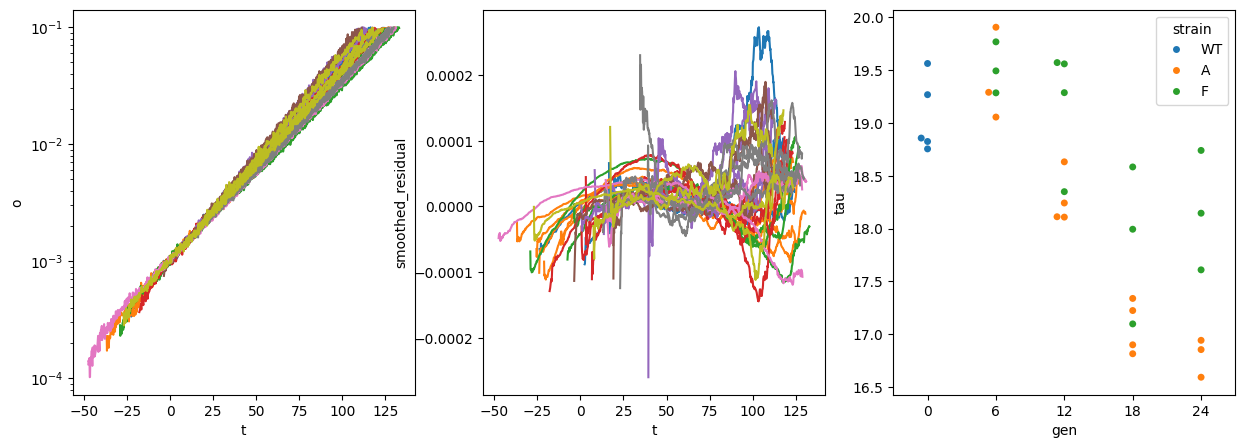

In [39]:
###########################
# Plot fits and residuals #
###########################

# Residuals
smoothing_window = 1000
gc_section['residual'] = gc_section.o - gc_section.pred_o
gc_section['smoothed_residual'] = gc_section.groupby('well')['residual'].transform(lambda s: s.rolling(window = smoothing_window, min_periods=1).mean())

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)

sns.lineplot(x = gc_section.t, y = gc_section.o, hue = gc_section['well'], style = gc_section['well'], dashes = False, legend = False, ax = axes[0])
axes.ravel()[0].set_yscale('log')
sns.lineplot(x = gc_section.t, y = gc_section.smoothed_residual, hue = gc_section['well'], style = gc_section['well'], dashes = False, legend = False, ax = axes[1])
sns.swarmplot(data = group_params, x = 'gen', y = 'tau', hue = 'strain', ax = axes[2])

In [ ]:
group_params.to_csv('group_params_' + experiment_name + '.tsv', sep = '\t', index = False)

# Kalman filters
Now we can try to track the subtle changes in growth rate over time.

In [41]:
# Educated guess for the parameters
print('Variance of OD zero:', float(np.var(group_params.od_zero)))
print('Variance of 1/tau:', float(np.var(1 / group_params.tau)))

print('Variance of residuals:', float(np.var(gc_section.residual)))

Variance of OD zero: 8.031439879152947e-11
Variance of 1/tau: 9.01602023629762e-06
Variance of residuals: 1.593066239066633e-06


In [45]:
def run_rts_smoother(times, measurements, ini_tau, gr_drift=1e-8, od_noise = 1e-5):
    '''
    Estimates real ODs and growth rate using an Extended Kalman Filter followed by RTS smoothing.
    ini_tau: starting value for the doubling time
    gr_drift: autocovariance of the growth rate. Determines how fast the growth rate is allowed to vary.
    Returns (smoothed_ods, smoothed_doubling_times, filtered_ods, filtered_doubling_times).
    '''
    # Initial parameters
    od_zero = measurements[0]
    gr_zero = 1 / ini_tau
    od_var = 1e-8
    gr_var = 1.8e-7

    # Initialize state variables
    initial_state = np.array([[od_zero], [gr_zero]])
    P = np.array([[od_var, 0.0],
                  [0.0, gr_var]])
    Q = np.array([[0.0, 0.0],
                  [0.0, gr_drift]])
    R = np.array([[od_noise]])

    # Lists to store forward pass results
    filtered_states = [initial_state]
    filtered_covs = [P]
    predicted_states = []
    predicted_covs = []
    F_jacobians = []

    prev_t = 2 * times[0] - times[1]
    state = initial_state
    
    # Forward pass (Kalman filter)
    for t, z in zip(times, measurements):
        dt = t - prev_t
        prev_t = t
        
        # State prediction
        OD, growth_rate = state[0, 0], state[1, 0]
        OD_new = OD * 2 ** (growth_rate * dt)
        state_pred = np.array([[OD_new], [growth_rate]])
        
        # Jacobian calculation
        dfdOD = 2 ** (growth_rate * dt)
        dfdgrowth_rate = OD * dt * np.log(2) * 2 ** (growth_rate * dt)
        F_jacobian = np.array([[dfdOD, dfdgrowth_rate],
                              [0.0, 1.0]])
        
        # Predict covariance
        P_pred = F_jacobian @ P @ F_jacobian.T + Q
        
        # Store predictions
        predicted_states.append(state_pred)
        predicted_covs.append(P_pred)
        F_jacobians.append(F_jacobian)
        
        # Measurement update
        H_jacobian = np.array([[1.0, 0.0]])
        y = np.array([[z]]) - np.array([[state_pred[0, 0]]])
        S = H_jacobian @ P_pred @ H_jacobian.T + R
        K = P_pred @ H_jacobian.T @ np.linalg.inv(S)
        
        # Update state and covariance
        state = state_pred + K @ y
        P = (np.eye(2) - K @ H_jacobian) @ P_pred
        
        # Store filtered results
        filtered_states.append(state)
        filtered_covs.append(P)

    # Extract filtered values (same shape as input measurements)
    filtered_ODs = np.array([state[0, 0] for state in filtered_states][:-1])
    filtered_growth_rates = np.array([state[1, 0] for state in filtered_states][:-1])
    filtered_doubling_times = 1/filtered_growth_rates

    # Backward pass (RTS smoother)
    smoothed_states = [filtered_states[-1]]
    smoothed_covs = [filtered_covs[-1]]
    
    for t in range(len(times)-2, -1, -1):
        # Get saved values from forward pass
        state_filtered = filtered_states[t]
        P_filtered = filtered_covs[t]
        state_pred = predicted_states[t]
        P_pred = predicted_covs[t]
        F = F_jacobians[t]
        
        # Calculate smoother gain
        C = P_filtered @ F.T @ np.linalg.inv(P_pred)
        
        # Update state and covariance
        state_smoothed = state_filtered + C @ (smoothed_states[0] - state_pred)
        P_smoothed = P_filtered + C @ (smoothed_covs[0] - P_pred) @ C.T
        
        # Store smoothed results
        smoothed_states.insert(0, state_smoothed)
        smoothed_covs.insert(0, P_smoothed)

    # Extract smoothed values (same shape as input measurements)
    smoothed_ODs = np.array([state[0, 0] for state in smoothed_states])
    smoothed_growth_rates = np.array([state[1, 0] for state in smoothed_states])
    smoothed_doubling_times = 1/smoothed_growth_rates

    return smoothed_ODs, smoothed_doubling_times, filtered_ODs, filtered_doubling_times

In [46]:
# Run the filter on all cultures
results = []

max_time = np.inf

for n, row in group_params.iterrows():
    
    name = row['name']
    tau = row['tau']
    well = row['well']
    rep = row['rep']
    
    sub = gc_initial_fit[(gc_initial_fit.well == well) & (gc_initial_fit.elapsed_raw < max_time)].reset_index(drop = True)

    times = sub.t
    measurements = sub.o
    #ini_tau = sub.ini_tau[0]

    estimated_OD, estimated_tau, filtered_OD, filtered_tau = run_rts_smoother(times, measurements, tau, gr_drift=1e-8)
    
    strain = sub.strain[0]
    gen = sub.gen[0]
    #rep = sub.rep[0]
    
    results.append(pd.DataFrame({'well': well, 'name': name, 'strain': strain, 'gen': gen, 'rep': rep, 't': times, 'o': measurements, 'o_filt': filtered_OD, 'o_estimate': estimated_OD, 'tau_filt': filtered_tau, 'tau_estimate': estimated_tau}))
    
gc_kf = pd.concat(results)

# Save values
gc_kf.to_csv('growth_dynamics_' + experiment_name + '.tsv', sep = '\t', index = False)

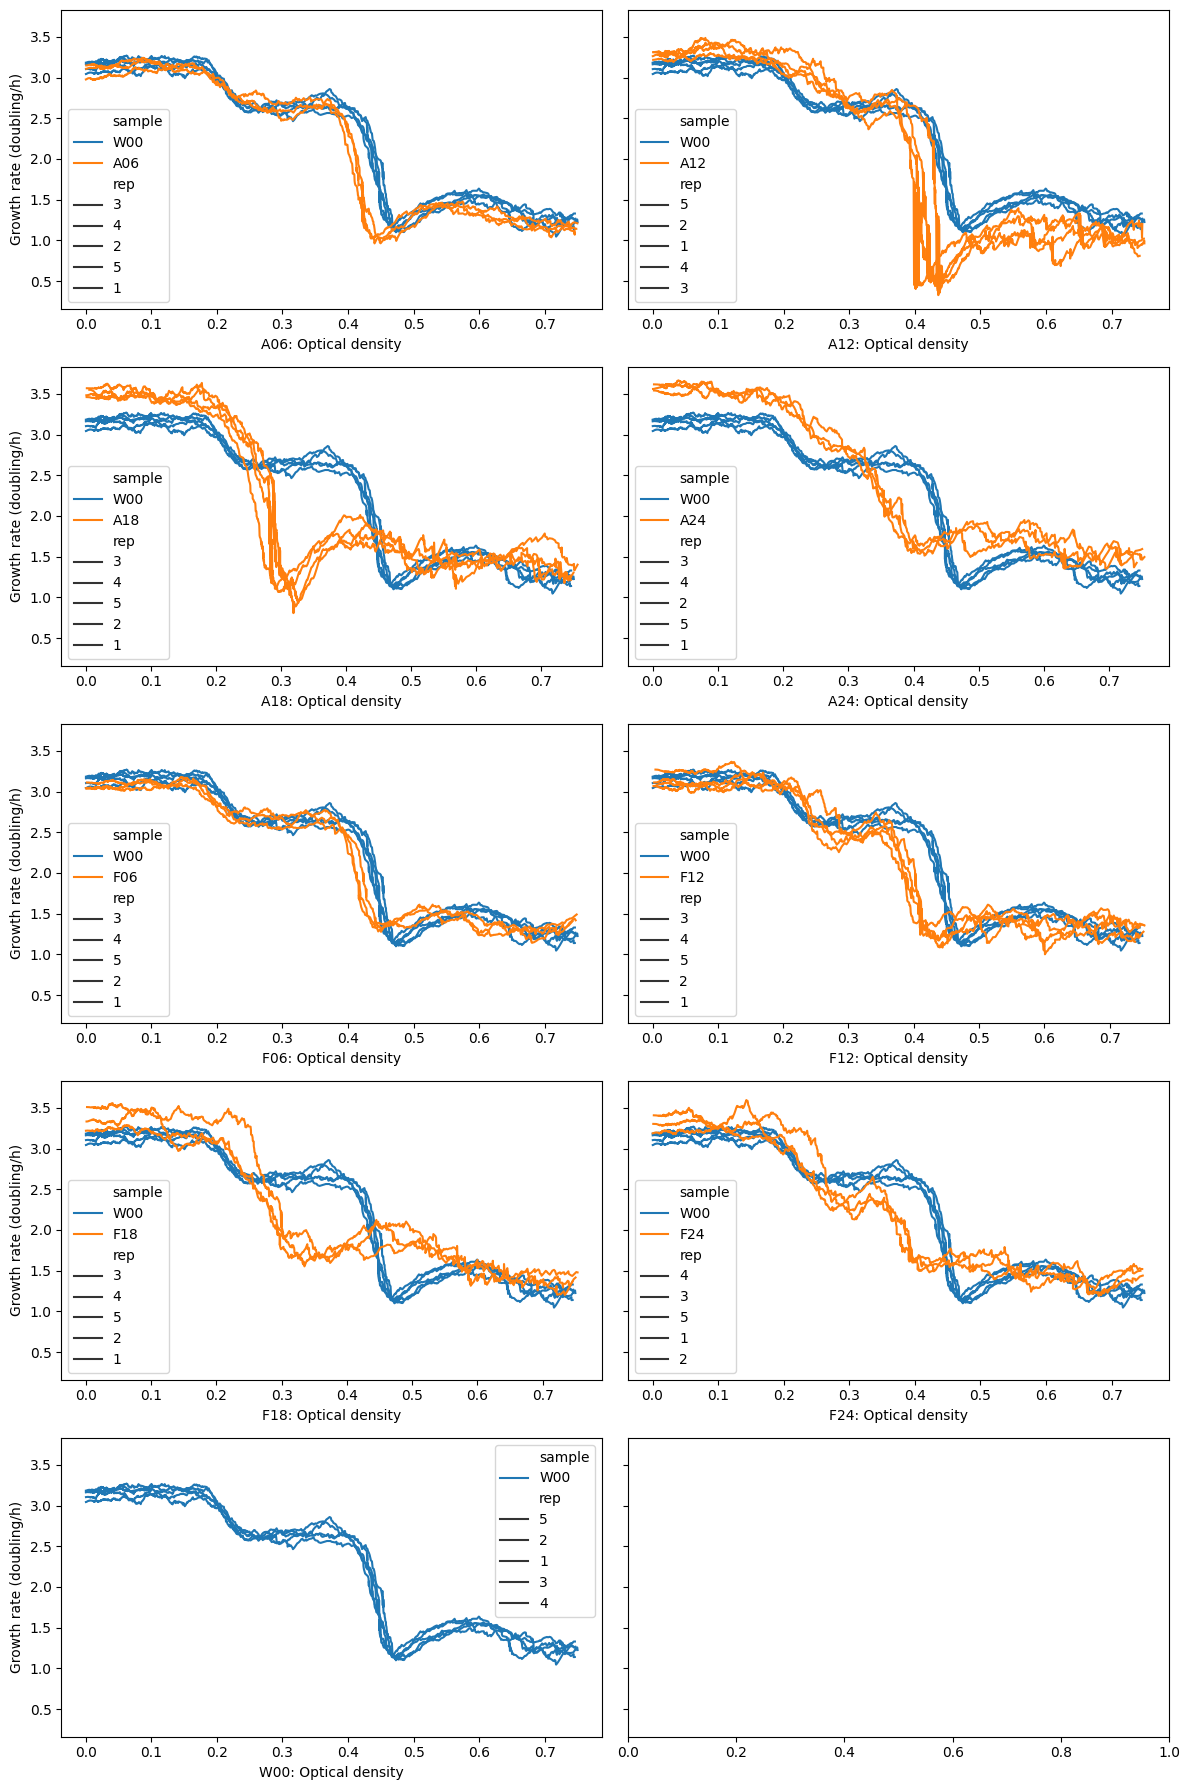

In [60]:
n_col = 2
fig, axes = plt.subplots(int(12 / n_col), n_col, figsize=(12, 18), sharey = True)

for n, i in enumerate(np.unique(gc_kf['name'])):
    sub_kf = gc_kf[(gc_kf.o_estimate <= 0.75) & (gc_kf['name'].isin(['W00', i]))].sort_values(['gen'])
    sns.lineplot(x = sub_kf.o_filt, y = 60/sub_kf.tau_filt, hue = sub_kf['name'], style = sub_kf.rep, dashes = False,
                 ax = axes[n//n_col][n%n_col], legend = True)
    
    axes.ravel()[n].set_xlabel(f'{i}: Optical density')
    axes.ravel()[n].set_ylabel(f'Growth rate (doubling/h)')
    #axes.ravel()[n].set_ylim(0, 150)
            
plt.tight_layout()